In [1]:
import numpy as np
from PIL import Image
import os

import torch
import torchvision.models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
def load_image(directory):
    images = {}  # dimension: list of images
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png')):

                # load image
                file_path = os.path.join(root, file)
                img = Image.open(file_path).convert("RGBA")
                w, h = img.size
                if not (w == h and w >= 72 and h >= 72):
                    continue

                # add dimension
                if (w, h) not in images:
                    images[(w, h)] = []
                img = img.resize((64, 64))
                images[(w, h)].append(np.array(img))

    print(sorted([(_[0], len(_[1])) for _ in images.items()], key=lambda _: -_[1]))

    images = sorted(images.values(), key=lambda _: -len(_))
    images = np.array(images[0])
    print(images.shape)
    return images

# input_images = load_image('data/noto-emoji/png/72/')
input_images = load_image('data/')

[((120, 120), 7664), ((72, 72), 7620), ((128, 128), 3576), ((512, 512), 3576), ((108, 108), 986), ((160, 160), 6), ((1000, 1000), 1), ((500, 500), 1)]
(7664, 64, 64, 4)


In [3]:
def encode_image(model, images):
    def encode_image_inner(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        img = torch.tensor(img, dtype=torch.float32) / 255.0
        img = torch.permute(img, (0, 3, 1, 2))
        img = (img[:,:3] - mean) / std
        with torch.no_grad():
            img = model(img.to(device))
        # print(img.shape)
        return torch.flatten(img, start_dim=1)
    dim = encode_image_inner(images[0:1]).shape[1]
    print(dim)
    encoded = torch.zeros((len(images), dim))
    batch = 256
    for i in range(0, len(images), batch):
        img = images[i:i+batch]
        code = encode_image_inner(img)
        encoded[i:i+len(code)] = code
    return encoded

vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
# print(vgg16)
# vgg16_head = vgg16.features[:5]
vgg16_head = vgg16.features[:10]
# vgg16_head = vgg16.features[:17]
# vgg16_head = vgg16.features[:24]
# vgg16_head = vgg16.features
vgg16_encoder = torch.nn.Sequential(
    vgg16_head,
    torch.nn.AdaptiveAvgPool2d(output_size=(4, 4))
    ).to(device)
for param in vgg16_encoder.parameters():
    param.requires_grad = False
# print(vgg16_encoder)

encoded_images = encode_image(vgg16_encoder, input_images)
encoded_images = encoded_images.numpy()
print(encoded_images.shape)

2048
(7664, 2048)


/home/harry7557558/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


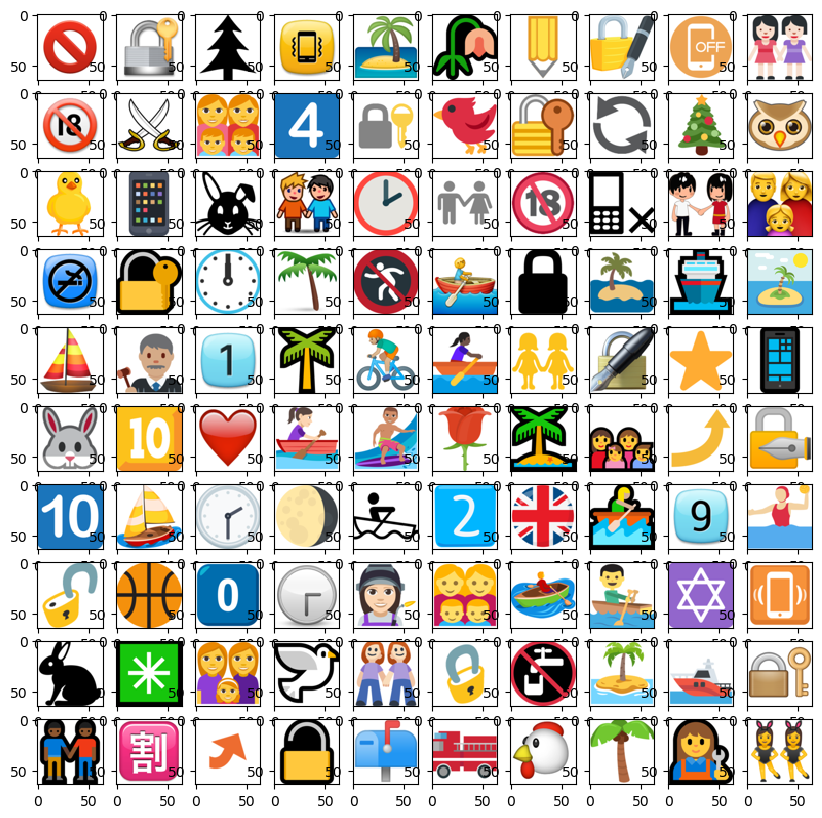

In [5]:
data = encoded_images

from sklearn.cluster import MiniBatchKMeans

# Assuming you have M N-dimensional vectors in a NumPy array 'data'
# M is the number of vectors, N is the dimensionality of each vector
# K is the number of clusters you want to create
M, N = data.shape
K = 100  # Adjust K as needed

# Create and fit the MiniBatchKMeans model
minibatch_kmeans = MiniBatchKMeans(n_clusters=K, random_state=42)
minibatch_kmeans.fit(data)

# Get the cluster assignments and indices for each vector
cluster_assignments = minibatch_kmeans.labels_
indices_per_cluster = [np.where(cluster_assignments == i)[0] for i in range(K)]

# Choose one representative index from each cluster
unique_indices = np.array([indices[0] for indices in indices_per_cluster])

import matplotlib.pyplot as plt

k = K
grid_nx = int(np.ceil(k**0.5))
grid_ny = int(np.ceil(k/grid_nx))
fig, axs = plt.subplots(grid_ny, grid_nx, figsize=(grid_nx, grid_ny))
for i in range(k):

    ax = axs[i//grid_nx, i%grid_nx]
    ax.imshow(input_images[unique_indices[i]])
plt.show()